**Transfer learning is a technique in machine learning where a model developed for one task is reused as the starting point for a model on a second task. This approach is particularly useful in image classification tasks.**

Imagine you have trained a model on large variety of images, and this model have learned to detect the edges, shapes, patterns and other aspects of the image.

But now you wish to build a model for another specific image classification task. so instead of training a new model from scratch you can use the knowledge of laready pretrained model for foundation

Two main approaches to achieve this

**Freezing the layers**
* you take a pretrained model and remove it's final classification layer
* you add your own classification depending on your classification task
* The pretrained layers are frozen so the new classifier can learn from your data. The weights of the frozen layers aren't updated

**Fine-Tuning**
* After adding your own classifier you unfreeze some of the pretrained layers
* You then train the entire model on your dataset
* This allows the model to adjust it's prelearned feature to adjust according to your task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-04-12 19:14:41.989651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744485282.261853      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744485282.347863      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir='/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry'

train_dir = pathlib.Path(train_dir)


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (200, 200)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  subset="training",
validation_split=0.2,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.


2025-04-12 19:15:04.969014: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  subset="validation",
validation_split=0.2,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


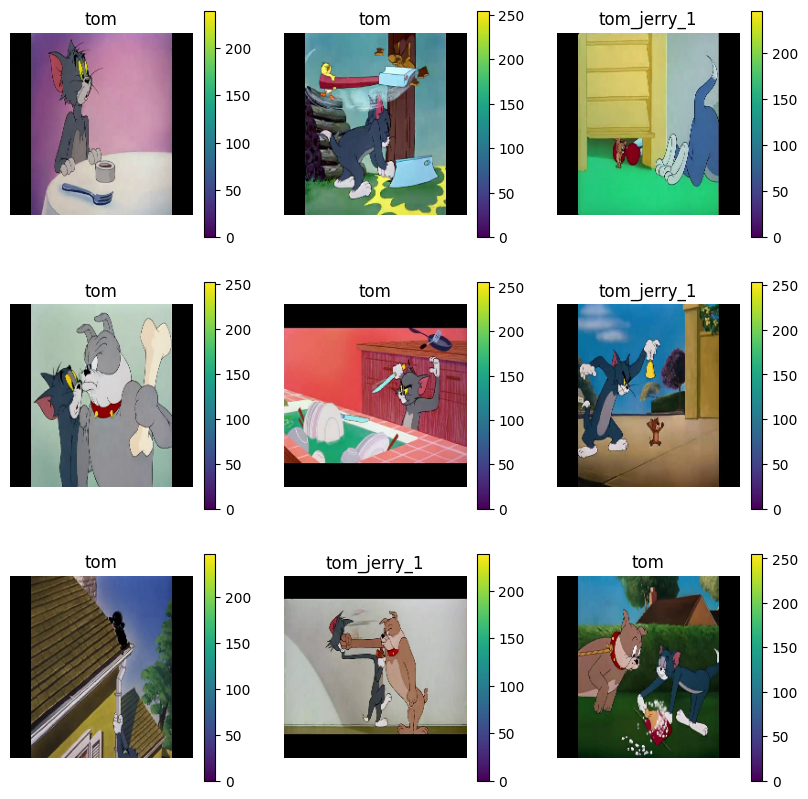

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.colorbar()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for images, labels in train_ds.take(1):
    image = tf.image.convert_image_dtype(images, tf.float32)
    
    # Find the maximum pixel value so that we can scale the pixel values between 0 to 1
    max_pixel_value = tf.reduce_max(image)
    print(max_pixel_value)

tf.Tensor(255.0, shape=(), dtype=float32)


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Now we use the pretrained model which is MobileNetV2. 

MobileNetV2 is a convolutional neural network architecture designed for efficient computation, making it suitable for mobile and embedded vision applications. It introduces two key concepts:​

Inverted Residuals: These are connections that help preserve information across layers by connecting the input and output of a sequence of operations.​

Linear Bottlenecks: These are layers that reduce the dimensionality of the data, helping to maintain essential information while reducing computational complexity. 

What is a bottleneck layer?
bottleneck layer refers to the final layer before the model's classification layer.
This layer containes rich high level data extracted from the input images.
By utilizing this layer for feature extraction, we can extract the most informative aspects from the images without utilizing the classification layer.

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# creating a base model from the pretrained mobilenet model
# include_top=False does not include the classification layer

/tmp/ipykernel_13/3484121605.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
base_model.trainable = False
# this will freeze the feature layers of the model which prevents updating the original weights 
# during actual training

Understanding BatchNormalization Behavior

During Training: BatchNormalization layers compute the mean and variance of each batch and update internal statistics (moving averages) accordingly

During Inference: These layers use the stored moving averages to normalize inputs, ensuring consistent behavior

 Fine-Tuning with BatchNormalization Layers
When you unfreeze a pre-trained model for fine-tuning, the BatchNormalization layers may resume updating their internal statistics, which can disrupt the model's learned features. To prevent this:​

Keep BatchNormalization Layers in Inference Mode: Pass training=False when calling the base model during fine-tuning. This ensures that BatchNormalization layers use their stored statistics and do not update them.

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 100, 100, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 100, 100, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 100, 100, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 100, 100, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 100, 100, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 100, 100, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 100, 100, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 100, 100, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 100, 100, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 100, 100, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 100, 100, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 101, 101, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 50, 50, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
# we are just considering a single batch of images to apply the classification layers.
# hence we use the next iter insteading of looping on the all the batches.
# just to verify that the base model is working properly this one batch is selected


(32, 7, 7, 1280)


In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
# this layer reduces the spatial dimension from the convolution by averaging them to give one number
#This is a common way to reduce the output of a convolutional base into a flat vector that you can:

#Feed into a dense (fully connected) layer

#Use for classification, regression, etc.
# and this layer is applied on the image batches only


(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
# this is the final classification layer

(32, 6)


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocessing the pixel values as this pre trained model considers pixel values between -1 to 1



```python
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
```

why defining the **`outputs` explicitly is necessary**.

---

### 🔧 What’s happening here?

```python
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
```

- `inputs` is the input tensor:  
  → Defined by `tf.keras.Input(...)`
- `x` is your transformed data as it passes through the model
- `outputs` is the final tensor after all transformations  
  → It’s the **actual prediction** you want the model to produce

You're telling Keras:

> "Here's where data **comes in**, and here’s where it **comes out** — connect the dots and build me a model."

---

### 🎯 Why is `outputs` important?

Because `tf.keras.Model(inputs, outputs)` defines a **computational graph** — a map of how data flows from input to output.

Without defining `outputs`, Keras wouldn’t know:
- What part of the network is the **final output**
- Where to compute the **loss**
- What to backpropagate during training

---

### 🤔 What if you forget `outputs`?

If you do something like:

```python
model = tf.keras.Model(inputs, x)  # assuming x is NOT the final output
```

Then you're not getting the final predictions — you might get an **intermediate tensor**, not what you actually want the model to predict.

---

### 📦 Analogy

Imagine you're assembling a machine on a conveyor belt:
- `inputs` = the raw material going in
- `x` = all the steps on the conveyor
- `outputs` = the final packaged product

If you don’t tell the system **where the product comes out**, it has no idea where to end the process.

---

### TL;DR

Defining `outputs = prediction_layer(x)`:
- 📌 Tells Keras what the **final output** of the model is
- 🔄 Allows it to compute predictions, loss, and backprop
- 🧠 Builds the full model: `model = Model(inputs, outputs)`

Without that line, your model would be incomplete.

Let me know if you want a visual or step-by-step graph of what happens!

In [16]:
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

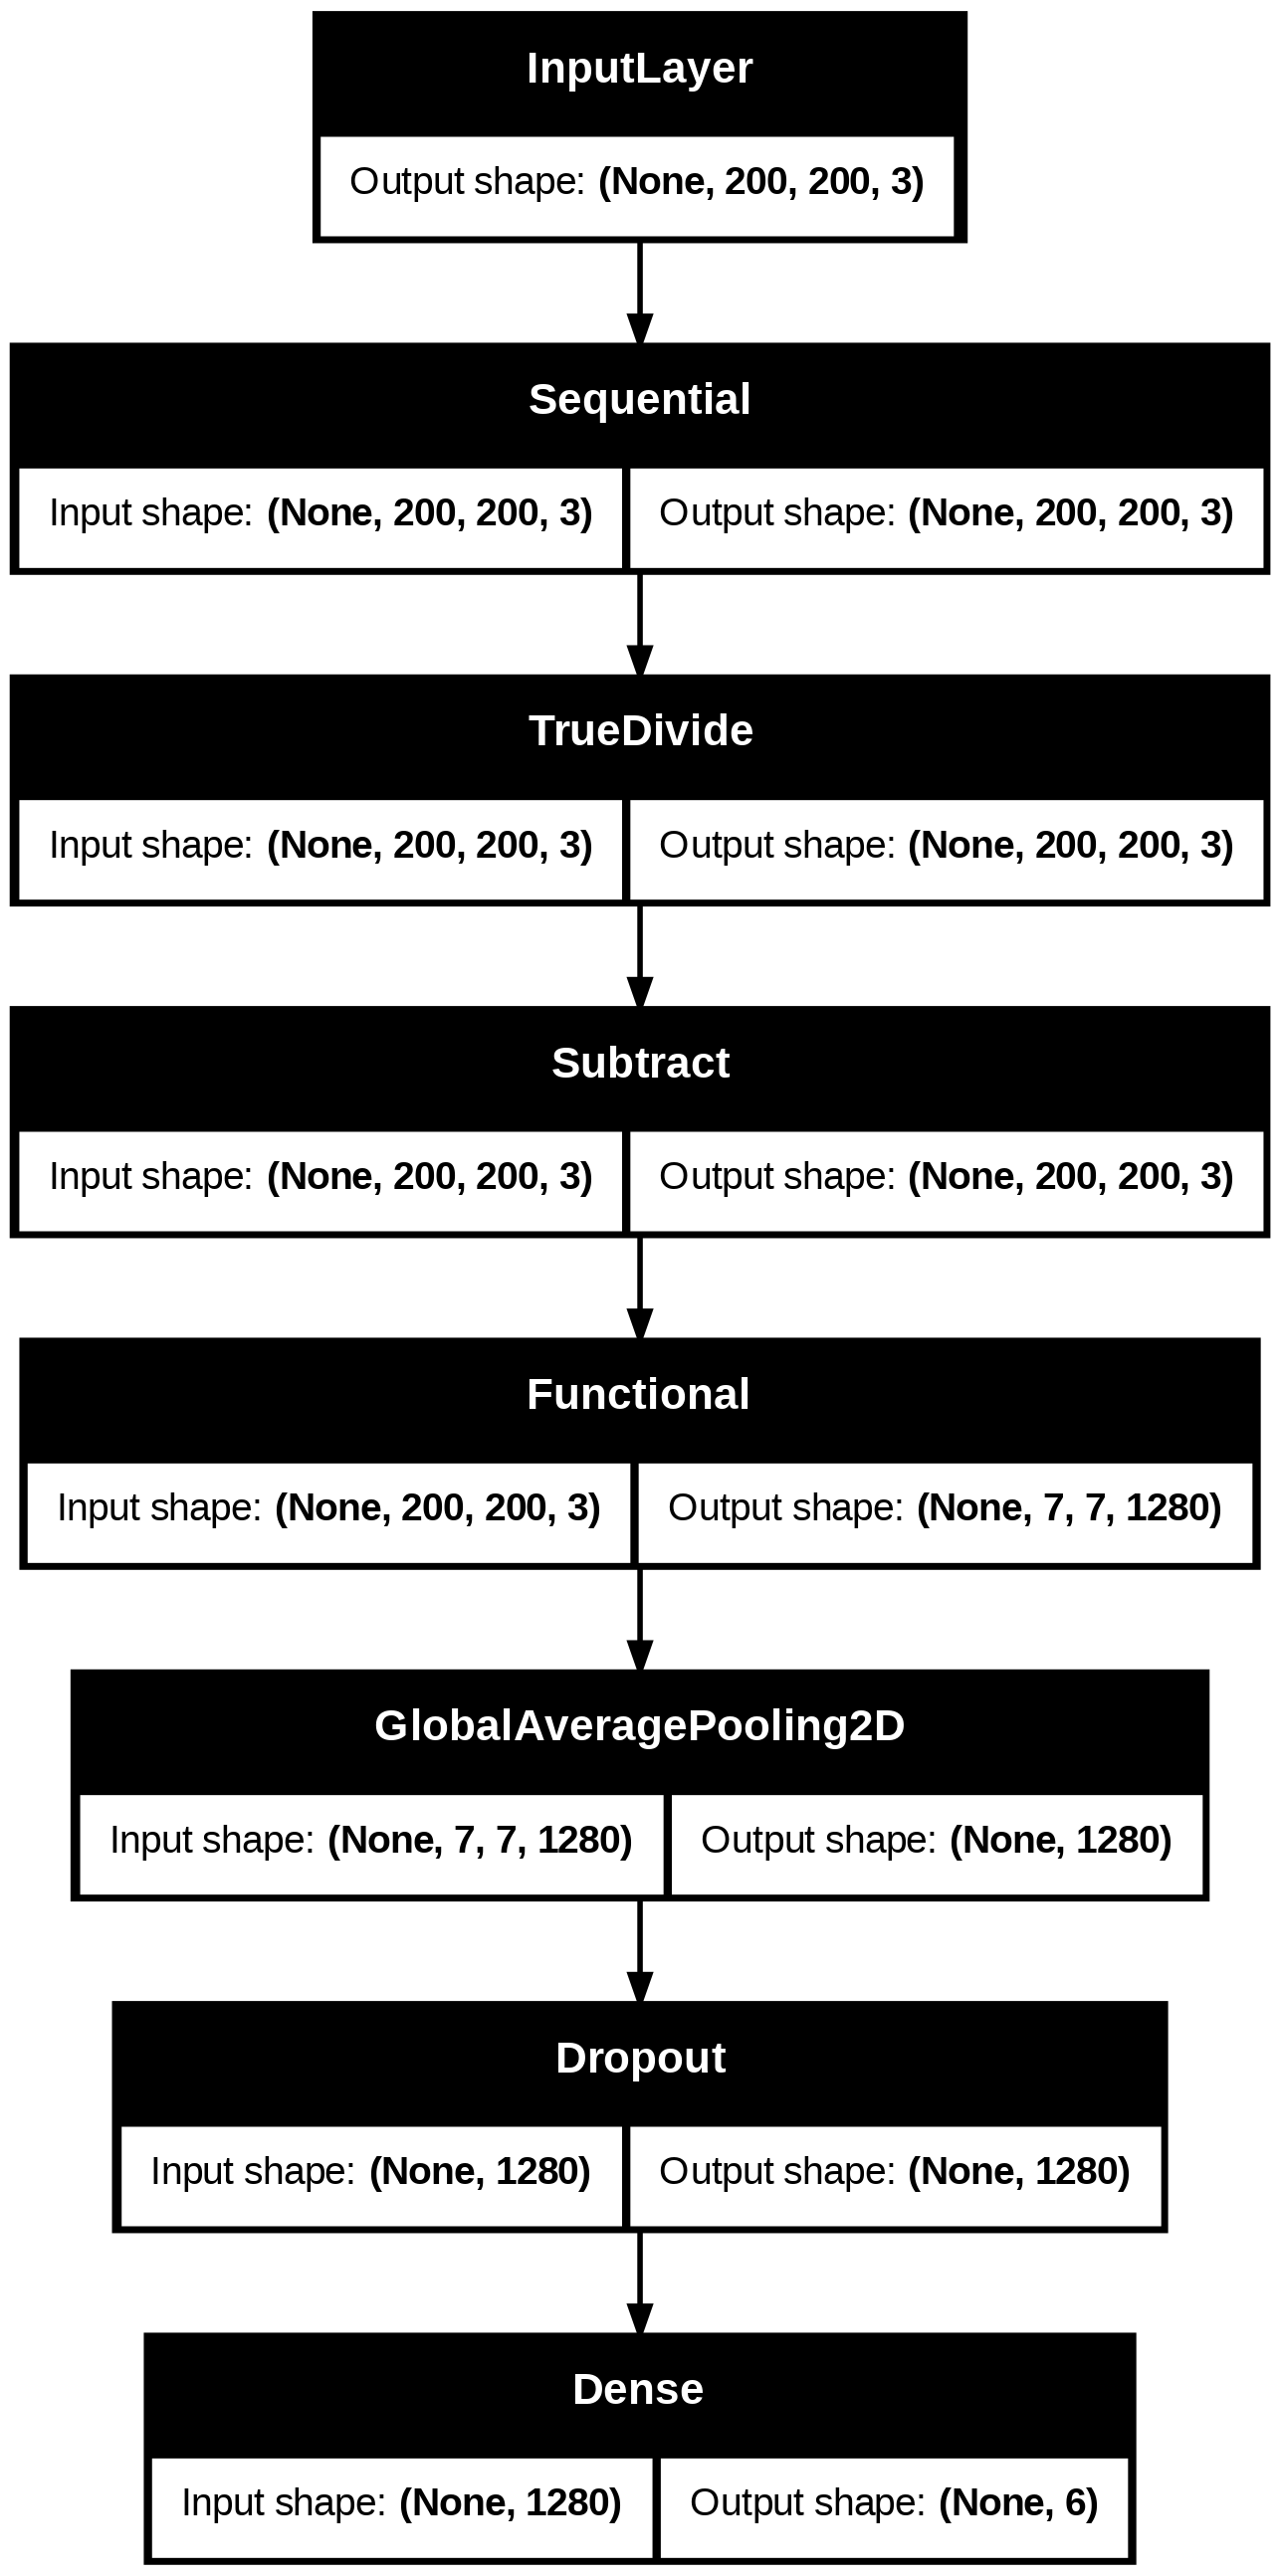

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
 

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 912ms/step - accuracy: 0.3809 - loss: 1.4606 - val_accuracy: 0.5589 - val_loss: 1.0310


In [20]:
image_path='/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/jerry/frame100.jpg'
img_height, img_width=200,200
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to tom_jerry_0 with a 26.49 percent confidence.
